In [1]:
import sys, os
import torch
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple, Dict
# Add parent directory (project/)
sys.path.append(os.path.abspath("/Users/pratyushuppuluri/Desktop/Summer/CARL"))

# from models.generator import Generator
# from models.encoder import Encoder

from ctrl_trainer import BiCoGAN,train_offline_d3qn
from ctrl_data import CTRL_CartPoleSD_CLEAN,make_SD_dataset,CTRLTransitionDataset,generate_cf_dataset,build_training_buffer
from ctrl_models import GeneratorCartPoleMLP,DiscriminatorCTRL,EncoderCTRL,QNetCTRL
from ctrl_utilities import evaluate_policy,plot_losses,test_counterfactual_quality,plot_d3qn_training,remove_outliers,summary,diagnostic_plots
from torch.utils.data import Dataset, DataLoader

def diagnostic_plots(real_means_clean,cf_means_clean,real_means,cf_means,real_vars_clean, cf_vars_clean):
    # --------------------------------------------------------
    # 4. PLOTS — HISTOGRAMS OF MEANS
    # --------------------------------------------------------
    plt.figure(figsize=(12,5))
    sns.histplot(real_means_clean, kde=True, color='blue', label='Real', bins=10, alpha=0.5)
    sns.histplot(cf_means_clean,   kde=True, color='red',  label='CF',   bins=10, alpha=0.5)
    plt.title("Distribution of Mean Returns")
    plt.xlabel("Mean Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    # --------------------------------------------------------
    # 5. BOXPLOTS FOR MEANS
    # --------------------------------------------------------
    plt.figure(figsize=(8,5))
    plt.boxplot([real_means_clean, cf_means_clean], labels=["Real", "CF"])
    plt.title("Boxplot: Mean Returns (Outliers Removed)")
    plt.ylabel("Mean Return")
    plt.grid(True)
    plt.show()
    
    
    # --------------------------------------------------------
    # 6. BOXPLOTS FOR VARIANCES
    # --------------------------------------------------------
    plt.figure(figsize=(8,5))
    plt.boxplot([real_vars_clean, cf_vars_clean], labels=["Real", "CF"])
    plt.title("Boxplot: Variance (Std²) of Returns")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.show()
    
    
    # --------------------------------------------------------
    # 7. OVERLAYED MEAN CURVES
    # --------------------------------------------------------
    plt.figure(figsize=(10,5))
    plt.plot(real_means, marker='o', label="Real Means")
    plt.plot(cf_means, marker='x', label="CF Means")
    plt.title("Mean Return per Evaluation Iteration")
    plt.xlabel("Evaluation Index")
    plt.ylabel("Mean Return")
    plt.legend()
    plt.grid(True)
    plt.show() 

class Args:
    udim = 4

    # Stage 1 pretraining
    pre_train_lr = 1e-3
    pre_train_epochs = 15

    # Main adversarial stage
    lr    = 1e-4
    disc_lr = 1e-4
    beta1 = 0.5
    beta2 = 0.9
    num_epochs = 50

    # Gamma schedule (EFL scale)
    alpha = 0.1
    rho   = 5e-5
    phi   = 10.0




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_ACTIONS = 11  # discrete actions 0..10


def main(USE_CF=True,CF_K_PER_REAL = 1 ):
    print("Loading CLEAN SD dataset...")
    real_data = torch.load("SD_dataset_clean.pt")
    # Optionally load BiCoGAN models and build real+CF buffer
    if USE_CF:
        #G, E = load_bicogan_models()
        S_raw, A, R, SP_raw = build_training_buffer(
            real_data,
            use_cf=True,
            G=G,
            E=E,
            cf_k=CF_K_PER_REAL,
        )
        label = f"Real+CF (k={CF_K_PER_REAL}) D3QN+CQL"
    else:
        # Real-only
        S_raw = real_data["s"].float().reshape(-1, 4)
        A     = real_data["a"].long().reshape(-1)
        R     = real_data["r"].float().reshape(-1)
        SP_raw = real_data["sp"].float().reshape(-1, 4)
        label = "Real-only D3QN+CQL"

    N = S_raw.shape[0]
    print("Dataset transitions:", N)

    # -----------------------------
    # 2. Termination flags from NEXT state (clean thresholds)
    # -----------------------------
    D = (
        (SP_raw[:, 0] < -2.4)
        | (SP_raw[:, 0] > 2.4)
        | (SP_raw[:, 2] < -0.2095)
        | (SP_raw[:, 2] > 0.2095)
    ).float()

    # -----------------------------
    # 3. State normalization
    # -----------------------------
    S_mean = S_raw.mean(dim=0, keepdim=True)
    S_std  = S_raw.std(dim=0, keepdim=True) + 1e-6

    S  = (S_raw  - S_mean) / S_std
    SP = (SP_raw - S_mean) / S_std

    # -----------------------------
    # 4. Hyperparameters
    # -----------------------------
    hyper = D3QNHyperParams()

    # -----------------------------
    # 5. Train offline D3QN + CQL
    # -----------------------------
    q_net, tot, tdl, cql, qmean, qstd,valist = train_offline_d3qn(
        S,
        A,
        R,
        SP,
        D,
        hyper,
        S_mean,
        S_std,
        eval_every=20,
        label=label,
    )

    # -----------------------------
    # 6. Plot training curves
    # -----------------------------
    plot_d3qn_training(tot, tdl, cql, qmean, qstd, title=label)

    # -----------------------------
    # 7. Final evaluation on clean CartPole
    # -----------------------------
    final_returns = evaluate_policy(q_net, S_mean, S_std, episodes=20)
    print("\n================ FINAL EVALUATION ================")
    print("Mean return:", float(final_returns.mean()))
    print("Std return :", float(final_returns.std()))
    print("=================================================\n")
    return valist,final_returns

class D3QNHyperParams:
    epochs: int = 1000
    gamma: float = 0.99
    batch_size: int = 512
    lr: float = 1.5e-4
    tau: float = 0.005                 # target update rate
    alpha_cql: float = 0.02            # CQL weight
    reward_clip: Optional[float] = None
    target_clip: Optional[float] = 20.0
    max_grad_norm: Optional[float] = 1.0


Saved CLEAN SD dataset → SD_dataset_clean.pt
{'s': torch.Size([4149, 4]), 'a': torch.Size([4149]), 'acont': torch.Size([4149]), 'r': torch.Size([4149]), 'sp': torch.Size([4149, 4])}
4149
5


/var/folders/1_/jmlm_4tj4k18gv9r77l0vwkw0000gn/T/ipykernel_24073/2243771333.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("SD_dataset_clean.pt")



[Stage 1] Pretraining G...


Pretrain Epochs:   7%|█████▎                                                                          | 1/15 [00:00<00:01,  9.68it/s]

  Epoch 1: MSE=0.018363


Pretrain Epochs:  20%|████████████████                                                                | 3/15 [00:00<00:01, 10.44it/s]

  Epoch 2: MSE=0.002752
  Epoch 3: MSE=0.002691
  Epoch 4: MSE=0.002668


Pretrain Epochs:  33%|██████████████████████████▋                                                     | 5/15 [00:00<00:00, 10.52it/s]

  Epoch 5: MSE=0.002652
  Epoch 6: MSE=0.002687


Pretrain Epochs:  47%|█████████████████████████████████████▎                                          | 7/15 [00:00<00:00, 10.62it/s]

  Epoch 7: MSE=0.002667


Pretrain Epochs:  60%|████████████████████████████████████████████████                                | 9/15 [00:00<00:00, 10.54it/s]

  Epoch 8: MSE=0.002647
  Epoch 9: MSE=0.002649
  Epoch 10: MSE=0.002657


Pretrain Epochs:  73%|█████████████████████████████████████████████████████████▉                     | 11/15 [00:01<00:00, 10.59it/s]

  Epoch 11: MSE=0.002642
  Epoch 12: MSE=0.002591


Pretrain Epochs:  87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [00:01<00:00, 10.58it/s]

  Epoch 13: MSE=0.002578


Pretrain Epochs: 100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.53it/s]


  Epoch 14: MSE=0.002605
  Epoch 15: MSE=0.002596

[Stage 2] BiCoGAN training...


BiCoGAN Epochs:   2%|▋                                    | 1/50 [00:00<00:30,  1.61it/s, Adv=0.570, D=0.511, EFL=0.124, gamma=0.100]

Epoch 1/50 | D=0.5107  Adv=0.5704  EFL=0.1242  γ=0.100


BiCoGAN Epochs:   4%|█▍                                   | 2/50 [00:01<00:30,  1.59it/s, Adv=0.453, D=0.483, EFL=0.067, gamma=0.101]

Epoch 2/50 | D=0.4827  Adv=0.4525  EFL=0.0673  γ=0.101


BiCoGAN Epochs:   6%|██▏                                  | 3/50 [00:01<00:29,  1.58it/s, Adv=0.428, D=0.489, EFL=0.061, gamma=0.101]

Epoch 3/50 | D=0.4885  Adv=0.4275  EFL=0.0612  γ=0.101


BiCoGAN Epochs:   8%|██▉                                  | 4/50 [00:02<00:28,  1.59it/s, Adv=0.445, D=0.490, EFL=0.060, gamma=0.102]

Epoch 4/50 | D=0.4901  Adv=0.4445  EFL=0.0597  γ=0.102


BiCoGAN Epochs:  10%|███▋                                 | 5/50 [00:03<00:28,  1.59it/s, Adv=0.420, D=0.481, EFL=0.059, gamma=0.102]

Epoch 5/50 | D=0.4811  Adv=0.4200  EFL=0.0587  γ=0.102


BiCoGAN Epochs:  12%|████▍                                | 6/50 [00:03<00:27,  1.58it/s, Adv=0.424, D=0.485, EFL=0.059, gamma=0.102]

Epoch 6/50 | D=0.4847  Adv=0.4237  EFL=0.0587  γ=0.102


BiCoGAN Epochs:  14%|█████▏                               | 7/50 [00:04<00:27,  1.56it/s, Adv=0.420, D=0.480, EFL=0.058, gamma=0.103]

Epoch 7/50 | D=0.4802  Adv=0.4201  EFL=0.0582  γ=0.103


BiCoGAN Epochs:  16%|█████▉                               | 8/50 [00:05<00:27,  1.54it/s, Adv=0.413, D=0.484, EFL=0.058, gamma=0.103]

Epoch 8/50 | D=0.4841  Adv=0.4130  EFL=0.0581  γ=0.103


BiCoGAN Epochs:  18%|██████▋                              | 9/50 [00:05<00:26,  1.54it/s, Adv=0.416, D=0.479, EFL=0.058, gamma=0.103]

Epoch 9/50 | D=0.4789  Adv=0.4162  EFL=0.0581  γ=0.103


BiCoGAN Epochs:  20%|███████▏                            | 10/50 [00:06<00:25,  1.54it/s, Adv=0.414, D=0.482, EFL=0.058, gamma=0.104]

Epoch 10/50 | D=0.4820  Adv=0.4143  EFL=0.0576  γ=0.104


BiCoGAN Epochs:  22%|███████▉                            | 11/50 [00:07<00:25,  1.55it/s, Adv=0.416, D=0.481, EFL=0.057, gamma=0.104]

Epoch 11/50 | D=0.4809  Adv=0.4163  EFL=0.0574  γ=0.104


BiCoGAN Epochs:  24%|████████▋                           | 12/50 [00:07<00:24,  1.55it/s, Adv=0.410, D=0.479, EFL=0.057, gamma=0.105]

Epoch 12/50 | D=0.4793  Adv=0.4100  EFL=0.0574  γ=0.105


BiCoGAN Epochs:  26%|█████████▎                          | 13/50 [00:08<00:23,  1.55it/s, Adv=0.408, D=0.480, EFL=0.057, gamma=0.105]

Epoch 13/50 | D=0.4798  Adv=0.4075  EFL=0.0573  γ=0.105


BiCoGAN Epochs:  28%|██████████                          | 14/50 [00:08<00:23,  1.54it/s, Adv=0.408, D=0.477, EFL=0.057, gamma=0.105]

Epoch 14/50 | D=0.4768  Adv=0.4082  EFL=0.0573  γ=0.105


BiCoGAN Epochs:  30%|██████████▊                         | 15/50 [00:09<00:22,  1.53it/s, Adv=0.408, D=0.478, EFL=0.057, gamma=0.106]

Epoch 15/50 | D=0.4783  Adv=0.4085  EFL=0.0571  γ=0.106


BiCoGAN Epochs:  32%|███████████▌                        | 16/50 [00:10<00:22,  1.53it/s, Adv=0.410, D=0.482, EFL=0.057, gamma=0.106]

Epoch 16/50 | D=0.4824  Adv=0.4097  EFL=0.0573  γ=0.106


BiCoGAN Epochs:  34%|████████████▏                       | 17/50 [00:10<00:21,  1.53it/s, Adv=0.412, D=0.481, EFL=0.057, gamma=0.107]

Epoch 17/50 | D=0.4805  Adv=0.4117  EFL=0.0572  γ=0.107


BiCoGAN Epochs:  36%|████████████▉                       | 18/50 [00:11<00:20,  1.54it/s, Adv=0.407, D=0.477, EFL=0.057, gamma=0.107]

Epoch 18/50 | D=0.4768  Adv=0.4072  EFL=0.0571  γ=0.107


BiCoGAN Epochs:  38%|█████████████▋                      | 19/50 [00:12<00:20,  1.54it/s, Adv=0.408, D=0.481, EFL=0.057, gamma=0.107]

Epoch 19/50 | D=0.4812  Adv=0.4082  EFL=0.0569  γ=0.107


BiCoGAN Epochs:  40%|██████████████▍                     | 20/50 [00:12<00:19,  1.54it/s, Adv=0.411, D=0.483, EFL=0.057, gamma=0.108]

Epoch 20/50 | D=0.4829  Adv=0.4115  EFL=0.0568  γ=0.108


BiCoGAN Epochs:  42%|███████████████                     | 21/50 [00:13<00:18,  1.54it/s, Adv=0.413, D=0.483, EFL=0.057, gamma=0.108]

Epoch 21/50 | D=0.4826  Adv=0.4133  EFL=0.0570  γ=0.108


BiCoGAN Epochs:  44%|███████████████▊                    | 22/50 [00:14<00:18,  1.53it/s, Adv=0.415, D=0.485, EFL=0.057, gamma=0.109]

Epoch 22/50 | D=0.4846  Adv=0.4146  EFL=0.0568  γ=0.109


BiCoGAN Epochs:  46%|████████████████▌                   | 23/50 [00:14<00:17,  1.54it/s, Adv=0.407, D=0.476, EFL=0.057, gamma=0.109]

Epoch 23/50 | D=0.4756  Adv=0.4067  EFL=0.0567  γ=0.109


BiCoGAN Epochs:  48%|█████████████████▎                  | 24/50 [00:15<00:16,  1.54it/s, Adv=0.400, D=0.472, EFL=0.057, gamma=0.110]

Epoch 24/50 | D=0.4718  Adv=0.3997  EFL=0.0568  γ=0.110


BiCoGAN Epochs:  50%|██████████████████                  | 25/50 [00:16<00:16,  1.54it/s, Adv=0.414, D=0.486, EFL=0.057, gamma=0.110]

Epoch 25/50 | D=0.4865  Adv=0.4141  EFL=0.0567  γ=0.110


BiCoGAN Epochs:  52%|██████████████████▋                 | 26/50 [00:16<00:15,  1.54it/s, Adv=0.410, D=0.478, EFL=0.057, gamma=0.110]

Epoch 26/50 | D=0.4779  Adv=0.4100  EFL=0.0566  γ=0.110


BiCoGAN Epochs:  54%|███████████████████▍                | 27/50 [00:17<00:15,  1.53it/s, Adv=0.410, D=0.483, EFL=0.057, gamma=0.111]

Epoch 27/50 | D=0.4828  Adv=0.4097  EFL=0.0568  γ=0.111


BiCoGAN Epochs:  56%|████████████████████▏               | 28/50 [00:18<00:14,  1.52it/s, Adv=0.406, D=0.479, EFL=0.057, gamma=0.111]

Epoch 28/50 | D=0.4787  Adv=0.4059  EFL=0.0567  γ=0.111


BiCoGAN Epochs:  58%|████████████████████▉               | 29/50 [00:18<00:13,  1.52it/s, Adv=0.414, D=0.479, EFL=0.056, gamma=0.112]

Epoch 29/50 | D=0.4791  Adv=0.4140  EFL=0.0564  γ=0.112


BiCoGAN Epochs:  60%|█████████████████████▌              | 30/50 [00:19<00:13,  1.52it/s, Adv=0.398, D=0.475, EFL=0.056, gamma=0.112]

Epoch 30/50 | D=0.4751  Adv=0.3977  EFL=0.0564  γ=0.112


BiCoGAN Epochs:  62%|██████████████████████▎             | 31/50 [00:20<00:12,  1.52it/s, Adv=0.407, D=0.482, EFL=0.056, gamma=0.112]

Epoch 31/50 | D=0.4817  Adv=0.4074  EFL=0.0564  γ=0.112


BiCoGAN Epochs:  64%|███████████████████████             | 32/50 [00:20<00:11,  1.53it/s, Adv=0.417, D=0.485, EFL=0.056, gamma=0.113]

Epoch 32/50 | D=0.4850  Adv=0.4167  EFL=0.0564  γ=0.113


BiCoGAN Epochs:  66%|███████████████████████▊            | 33/50 [00:21<00:11,  1.53it/s, Adv=0.411, D=0.480, EFL=0.056, gamma=0.113]

Epoch 33/50 | D=0.4801  Adv=0.4111  EFL=0.0564  γ=0.113


BiCoGAN Epochs:  68%|████████████████████████▍           | 34/50 [00:22<00:10,  1.53it/s, Adv=0.409, D=0.479, EFL=0.056, gamma=0.114]

Epoch 34/50 | D=0.4789  Adv=0.4087  EFL=0.0564  γ=0.114


BiCoGAN Epochs:  70%|█████████████████████████▏          | 35/50 [00:22<00:09,  1.52it/s, Adv=0.406, D=0.476, EFL=0.056, gamma=0.114]

Epoch 35/50 | D=0.4760  Adv=0.4057  EFL=0.0563  γ=0.114


BiCoGAN Epochs:  72%|█████████████████████████▉          | 36/50 [00:23<00:09,  1.51it/s, Adv=0.406, D=0.484, EFL=0.056, gamma=0.115]

Epoch 36/50 | D=0.4838  Adv=0.4055  EFL=0.0564  γ=0.115


BiCoGAN Epochs:  74%|██████████████████████████▋         | 37/50 [00:24<00:08,  1.51it/s, Adv=0.410, D=0.477, EFL=0.056, gamma=0.115]

Epoch 37/50 | D=0.4769  Adv=0.4097  EFL=0.0562  γ=0.115


BiCoGAN Epochs:  76%|███████████████████████████▎        | 38/50 [00:24<00:07,  1.51it/s, Adv=0.403, D=0.475, EFL=0.056, gamma=0.116]

Epoch 38/50 | D=0.4752  Adv=0.4034  EFL=0.0562  γ=0.116


BiCoGAN Epochs:  78%|████████████████████████████        | 39/50 [00:25<00:07,  1.52it/s, Adv=0.407, D=0.476, EFL=0.056, gamma=0.116]

Epoch 39/50 | D=0.4762  Adv=0.4067  EFL=0.0561  γ=0.116


BiCoGAN Epochs:  80%|████████████████████████████▊       | 40/50 [00:26<00:06,  1.52it/s, Adv=0.407, D=0.481, EFL=0.056, gamma=0.116]

Epoch 40/50 | D=0.4812  Adv=0.4074  EFL=0.0559  γ=0.116


BiCoGAN Epochs:  82%|█████████████████████████████▌      | 41/50 [00:26<00:05,  1.52it/s, Adv=0.405, D=0.476, EFL=0.056, gamma=0.117]

Epoch 41/50 | D=0.4763  Adv=0.4055  EFL=0.0558  γ=0.117


BiCoGAN Epochs:  84%|██████████████████████████████▏     | 42/50 [00:27<00:05,  1.52it/s, Adv=0.400, D=0.476, EFL=0.056, gamma=0.117]

Epoch 42/50 | D=0.4759  Adv=0.4002  EFL=0.0559  γ=0.117


BiCoGAN Epochs:  86%|██████████████████████████████▉     | 43/50 [00:28<00:04,  1.51it/s, Adv=0.410, D=0.480, EFL=0.056, gamma=0.118]

Epoch 43/50 | D=0.4803  Adv=0.4095  EFL=0.0557  γ=0.118


BiCoGAN Epochs:  88%|███████████████████████████████▋    | 44/50 [00:28<00:03,  1.51it/s, Adv=0.408, D=0.478, EFL=0.056, gamma=0.118]

Epoch 44/50 | D=0.4785  Adv=0.4080  EFL=0.0558  γ=0.118


BiCoGAN Epochs:  90%|████████████████████████████████▍   | 45/50 [00:29<00:03,  1.52it/s, Adv=0.413, D=0.484, EFL=0.056, gamma=0.119]

Epoch 45/50 | D=0.4840  Adv=0.4126  EFL=0.0559  γ=0.119


BiCoGAN Epochs:  92%|█████████████████████████████████   | 46/50 [00:29<00:02,  1.52it/s, Adv=0.402, D=0.474, EFL=0.056, gamma=0.119]

Epoch 46/50 | D=0.4740  Adv=0.4019  EFL=0.0557  γ=0.119


BiCoGAN Epochs:  94%|█████████████████████████████████▊  | 47/50 [00:30<00:01,  1.54it/s, Adv=0.408, D=0.479, EFL=0.055, gamma=0.120]

Epoch 47/50 | D=0.4792  Adv=0.4079  EFL=0.0555  γ=0.120


BiCoGAN Epochs:  96%|██████████████████████████████████▌ | 48/50 [00:31<00:01,  1.53it/s, Adv=0.412, D=0.483, EFL=0.056, gamma=0.120]

Epoch 48/50 | D=0.4832  Adv=0.4119  EFL=0.0558  γ=0.120


BiCoGAN Epochs:  98%|███████████████████████████████████▎| 49/50 [00:31<00:00,  1.53it/s, Adv=0.411, D=0.481, EFL=0.056, gamma=0.120]

Epoch 49/50 | D=0.4812  Adv=0.4105  EFL=0.0556  γ=0.120


BiCoGAN Epochs: 100%|████████████████████████████████████| 50/50 [00:32<00:00,  1.53it/s, Adv=0.411, D=0.480, EFL=0.056, gamma=0.121]

Epoch 50/50 | D=0.4797  Adv=0.4106  EFL=0.0559  γ=0.121


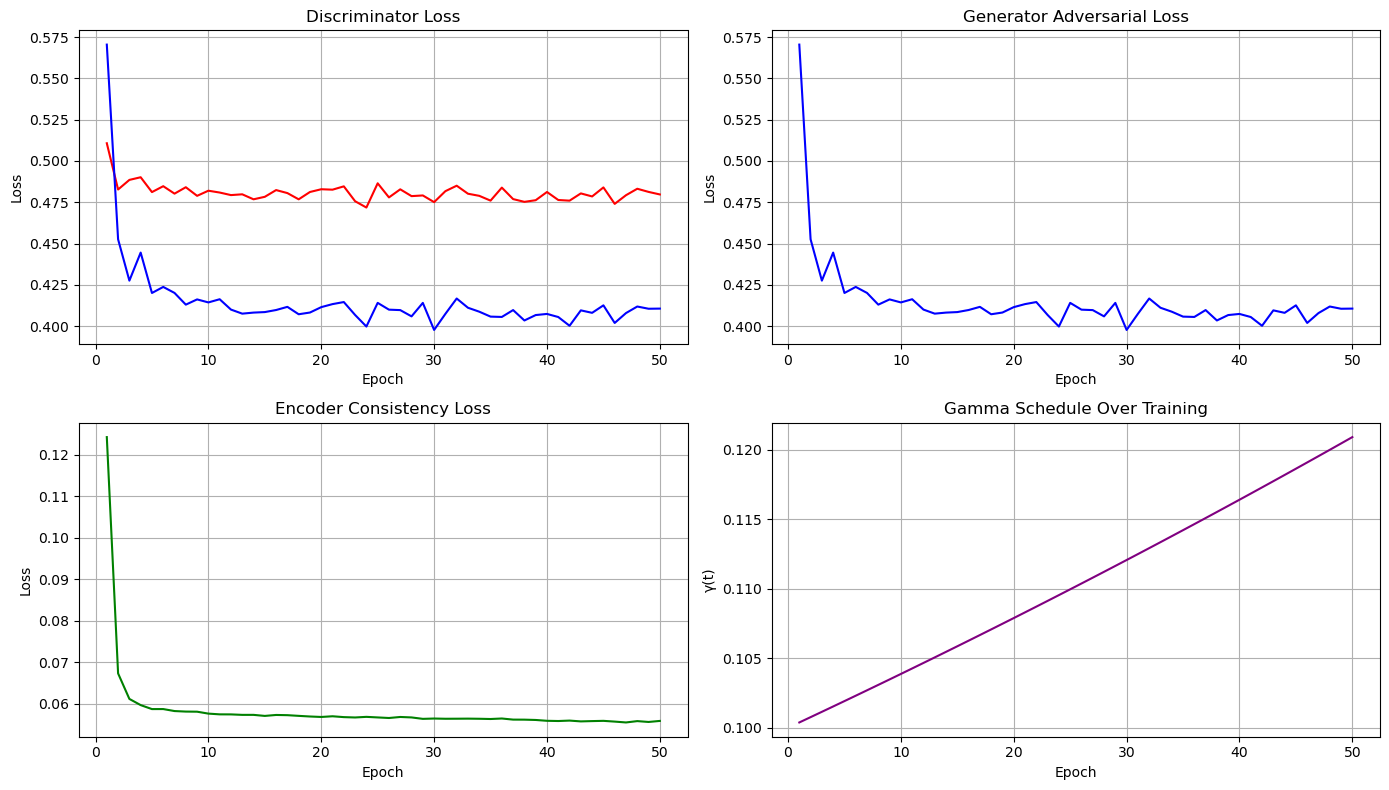


===== Counterfactual Quality Check =====
Reconstruction of next-state  sp_hat vs sp: 0.003646
Encoder reconstruction        s_hat  vs s : 0.009611
Encoder action prediction     a_hat  vs a : 0.075294



In [2]:
make_SD_dataset(num_eps=250, horizon=100, seed=0, save_path="SD_dataset_clean.pt")
obsdim = 4
udim   = 4
data = torch.load("SD_dataset_clean.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ds = CTRLTransitionDataset(data)
dl = DataLoader(ds, batch_size=54, shuffle=True, drop_last=True)

print(len(ds))        # should be 250 * 20 = 5000 
for batch in dl:
    print(len(batch)) # should print 5
    break


G = GeneratorCartPoleMLP(input_dim = obsdim + 1 + udim).to(device)
E = EncoderCTRL(obsdim=obsdim, udim=udim).to(device)
D = DiscriminatorCTRL(obsdim).to(device)

args = Args()
trainer = BiCoGAN(G, E, D, args)
trainer.train(dl)
plot_losses(trainer)
test_counterfactual_quality(G, E, dl,device)


/var/folders/1_/jmlm_4tj4k18gv9r77l0vwkw0000gn/T/ipykernel_24073/750496479.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  real_data = torch.load("SD_dataset_clean.pt"

Loading CLEAN SD dataset...
Generating 1 CF transitions per real transition...
Generated CF transitions: 4149
Total transitions (real + CF): 8298
Dataset transitions: 8298

========== OFFLINE D3QN TRAINING: Real+CF (k=1) D3QN+CQL ==========


D3QN Epochs:   0%|                                                                                  | 1/1000 [00:00<04:59,  3.34it/s]

Epoch 1/1000 | TD=0.7224 | CQL=0.0555 | Total=0.7779 | Qmean=-0.012 | Qstd=0.954
   ▶ Eval Return Mean = 9.85, Std = 2.41


D3QN Epochs:   2%|█▌                                                                               | 20/1000 [00:05<04:15,  3.83it/s]

Epoch 20/1000 | TD=0.7850 | CQL=0.0519 | Total=0.8369 | Qmean=-1.872 | Qstd=0.954
   ▶ Eval Return Mean = 11.50, Std = 3.89


D3QN Epochs:   4%|███▏                                                                             | 40/1000 [00:10<04:16,  3.74it/s]

Epoch 40/1000 | TD=0.4869 | CQL=0.0528 | Total=0.5396 | Qmean=-1.896 | Qstd=0.976
   ▶ Eval Return Mean = 20.60, Std = 16.45


D3QN Epochs:   6%|████▊                                                                            | 60/1000 [00:15<04:05,  3.83it/s]

Epoch 60/1000 | TD=0.8495 | CQL=0.0644 | Total=0.9140 | Qmean=-0.946 | Qstd=0.954
   ▶ Eval Return Mean = 9.45, Std = 0.67


D3QN Epochs:   8%|██████▍                                                                          | 80/1000 [00:20<03:55,  3.91it/s]

Epoch 80/1000 | TD=0.4233 | CQL=0.0518 | Total=0.4751 | Qmean=-2.314 | Qstd=0.954
   ▶ Eval Return Mean = 9.45, Std = 0.67


D3QN Epochs:  10%|████████                                                                        | 100/1000 [00:25<03:52,  3.87it/s]

Epoch 100/1000 | TD=0.3242 | CQL=0.0517 | Total=0.3760 | Qmean=-1.628 | Qstd=0.955
   ▶ Eval Return Mean = 9.45, Std = 0.67


D3QN Epochs:  12%|█████████▌                                                                      | 119/1000 [00:30<03:39,  4.01it/s]

Epoch 120/1000 | TD=0.3396 | CQL=0.0523 | Total=0.3920 | Qmean=-1.476 | Qstd=0.969


D3QN Epochs:  12%|█████████▌                                                                      | 120/1000 [00:30<04:36,  3.18it/s]

   ▶ Eval Return Mean = 94.70, Std = 67.52


D3QN Epochs:  14%|███████████▏                                                                    | 140/1000 [00:35<03:59,  3.59it/s]

Epoch 140/1000 | TD=0.3699 | CQL=0.0522 | Total=0.4221 | Qmean=-1.910 | Qstd=1.051
   ▶ Eval Return Mean = 41.00, Std = 14.90


D3QN Epochs:  16%|████████████▊                                                                   | 160/1000 [00:40<03:48,  3.68it/s]

Epoch 160/1000 | TD=0.3426 | CQL=0.0562 | Total=0.3988 | Qmean=-1.395 | Qstd=1.000
   ▶ Eval Return Mean = 33.15, Std = 12.25


D3QN Epochs:  18%|██████████████▍                                                                 | 180/1000 [00:45<03:34,  3.82it/s]

Epoch 180/1000 | TD=0.2967 | CQL=0.0518 | Total=0.3485 | Qmean=-1.635 | Qstd=0.984
   ▶ Eval Return Mean = 17.05, Std = 6.13


D3QN Epochs:  20%|████████████████                                                                | 200/1000 [00:51<03:47,  3.52it/s]

Epoch 200/1000 | TD=0.2795 | CQL=0.0521 | Total=0.3316 | Qmean=-1.777 | Qstd=0.971
   ▶ Eval Return Mean = 49.90, Std = 38.60


D3QN Epochs:  22%|█████████████████▌                                                              | 220/1000 [00:56<04:03,  3.20it/s]

Epoch 220/1000 | TD=0.2517 | CQL=0.0521 | Total=0.3038 | Qmean=-1.768 | Qstd=0.965
   ▶ Eval Return Mean = 85.85, Std = 99.89


D3QN Epochs:  24%|███████████████████▏                                                            | 240/1000 [01:01<03:41,  3.43it/s]

Epoch 240/1000 | TD=0.2294 | CQL=0.0517 | Total=0.2811 | Qmean=-1.838 | Qstd=0.963
   ▶ Eval Return Mean = 54.60, Std = 22.40


D3QN Epochs:  26%|████████████████████▊                                                           | 260/1000 [01:06<03:50,  3.21it/s]

Epoch 260/1000 | TD=0.2074 | CQL=0.0519 | Total=0.2594 | Qmean=-1.949 | Qstd=0.960
   ▶ Eval Return Mean = 79.90, Std = 31.90


D3QN Epochs:  28%|██████████████████████▍                                                         | 280/1000 [01:11<03:29,  3.44it/s]

Epoch 280/1000 | TD=0.1813 | CQL=0.0518 | Total=0.2332 | Qmean=-1.945 | Qstd=0.959
   ▶ Eval Return Mean = 57.80, Std = 40.44


D3QN Epochs:  30%|████████████████████████                                                        | 300/1000 [01:17<03:18,  3.53it/s]

Epoch 300/1000 | TD=0.1700 | CQL=0.0522 | Total=0.2221 | Qmean=-1.972 | Qstd=0.960
   ▶ Eval Return Mean = 39.25, Std = 15.18


D3QN Epochs:  32%|█████████████████████████▌                                                      | 320/1000 [01:22<03:12,  3.53it/s]

Epoch 320/1000 | TD=0.1486 | CQL=0.0514 | Total=0.2000 | Qmean=-1.970 | Qstd=0.960
   ▶ Eval Return Mean = 44.65, Std = 20.09


D3QN Epochs:  34%|███████████████████████████▏                                                    | 340/1000 [01:27<03:04,  3.58it/s]

Epoch 340/1000 | TD=0.1318 | CQL=0.0513 | Total=0.1832 | Qmean=-1.965 | Qstd=0.959
   ▶ Eval Return Mean = 35.15, Std = 21.62


D3QN Epochs:  36%|████████████████████████████▊                                                   | 360/1000 [01:32<02:58,  3.59it/s]

Epoch 360/1000 | TD=0.1151 | CQL=0.0510 | Total=0.1660 | Qmean=-1.956 | Qstd=0.959
   ▶ Eval Return Mean = 31.60, Std = 19.00


D3QN Epochs:  38%|██████████████████████████████▍                                                 | 380/1000 [01:38<03:04,  3.36it/s]

Epoch 380/1000 | TD=0.1057 | CQL=0.0507 | Total=0.1564 | Qmean=-1.953 | Qstd=0.959
   ▶ Eval Return Mean = 51.70, Std = 35.53


D3QN Epochs:  40%|████████████████████████████████                                                | 400/1000 [01:43<03:00,  3.32it/s]

Epoch 400/1000 | TD=0.0926 | CQL=0.0504 | Total=0.1430 | Qmean=-1.942 | Qstd=0.959
   ▶ Eval Return Mean = 23.10, Std = 13.35


D3QN Epochs:  42%|█████████████████████████████████▌                                              | 420/1000 [01:48<02:41,  3.59it/s]

Epoch 420/1000 | TD=0.0857 | CQL=0.0500 | Total=0.1358 | Qmean=-1.943 | Qstd=0.959
   ▶ Eval Return Mean = 40.50, Std = 26.70


D3QN Epochs:  44%|███████████████████████████████████▏                                            | 440/1000 [01:53<02:30,  3.73it/s]

Epoch 440/1000 | TD=0.0842 | CQL=0.0500 | Total=0.1342 | Qmean=-1.947 | Qstd=0.959
   ▶ Eval Return Mean = 28.50, Std = 15.24


D3QN Epochs:  46%|████████████████████████████████████▊                                           | 460/1000 [01:58<02:27,  3.66it/s]

Epoch 460/1000 | TD=0.0735 | CQL=0.0499 | Total=0.1234 | Qmean=-1.975 | Qstd=0.959
   ▶ Eval Return Mean = 30.30, Std = 14.42


D3QN Epochs:  48%|██████████████████████████████████████▍                                         | 480/1000 [02:03<02:19,  3.72it/s]

Epoch 480/1000 | TD=0.0669 | CQL=0.0498 | Total=0.1168 | Qmean=-1.980 | Qstd=0.959
   ▶ Eval Return Mean = 23.30, Std = 11.27


D3QN Epochs:  50%|████████████████████████████████████████                                        | 500/1000 [02:08<02:14,  3.73it/s]

Epoch 500/1000 | TD=0.0647 | CQL=0.0499 | Total=0.1146 | Qmean=-1.982 | Qstd=0.958
   ▶ Eval Return Mean = 25.55, Std = 13.07


D3QN Epochs:  52%|█████████████████████████████████████████▌                                      | 520/1000 [02:14<02:07,  3.75it/s]

Epoch 520/1000 | TD=0.0575 | CQL=0.0497 | Total=0.1072 | Qmean=-1.990 | Qstd=0.958
   ▶ Eval Return Mean = 25.30, Std = 11.55


D3QN Epochs:  54%|███████████████████████████████████████████▏                                    | 540/1000 [02:19<02:07,  3.61it/s]

Epoch 540/1000 | TD=0.0642 | CQL=0.0496 | Total=0.1138 | Qmean=-1.994 | Qstd=0.959
   ▶ Eval Return Mean = 24.25, Std = 11.73


D3QN Epochs:  56%|████████████████████████████████████████████▊                                   | 560/1000 [02:24<01:57,  3.74it/s]

Epoch 560/1000 | TD=0.0565 | CQL=0.0497 | Total=0.1062 | Qmean=-1.990 | Qstd=0.958
   ▶ Eval Return Mean = 20.40, Std = 11.66


D3QN Epochs:  58%|██████████████████████████████████████████████▍                                 | 580/1000 [02:29<01:53,  3.69it/s]

Epoch 580/1000 | TD=0.0484 | CQL=0.0494 | Total=0.0978 | Qmean=-1.965 | Qstd=0.958
   ▶ Eval Return Mean = 29.35, Std = 17.45


D3QN Epochs:  60%|████████████████████████████████████████████████                                | 600/1000 [02:34<01:50,  3.61it/s]

Epoch 600/1000 | TD=0.0457 | CQL=0.0492 | Total=0.0949 | Qmean=-1.959 | Qstd=0.958
   ▶ Eval Return Mean = 29.05, Std = 19.13


D3QN Epochs:  62%|█████████████████████████████████████████████████▌                              | 620/1000 [02:39<01:43,  3.66it/s]

Epoch 620/1000 | TD=0.0526 | CQL=0.0492 | Total=0.1019 | Qmean=-1.948 | Qstd=0.958
   ▶ Eval Return Mean = 19.35, Std = 13.40


D3QN Epochs:  64%|███████████████████████████████████████████████████▏                            | 640/1000 [02:44<01:37,  3.70it/s]

Epoch 640/1000 | TD=0.0417 | CQL=0.0489 | Total=0.0906 | Qmean=-1.924 | Qstd=0.958
   ▶ Eval Return Mean = 17.40, Std = 9.17


D3QN Epochs:  66%|████████████████████████████████████████████████████▊                           | 660/1000 [02:50<01:33,  3.64it/s]

Epoch 660/1000 | TD=0.0428 | CQL=0.0487 | Total=0.0915 | Qmean=-1.935 | Qstd=0.958
   ▶ Eval Return Mean = 27.00, Std = 24.37


D3QN Epochs:  68%|██████████████████████████████████████████████████████▍                         | 680/1000 [02:55<01:27,  3.64it/s]

Epoch 680/1000 | TD=0.0358 | CQL=0.0486 | Total=0.0844 | Qmean=-1.942 | Qstd=0.958
   ▶ Eval Return Mean = 29.45, Std = 24.79


D3QN Epochs:  70%|████████████████████████████████████████████████████████                        | 700/1000 [03:00<01:20,  3.74it/s]

Epoch 700/1000 | TD=0.0309 | CQL=0.0488 | Total=0.0797 | Qmean=-1.953 | Qstd=0.958
   ▶ Eval Return Mean = 22.45, Std = 15.30


D3QN Epochs:  72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [03:05<01:15,  3.69it/s]

Epoch 720/1000 | TD=0.0400 | CQL=0.0488 | Total=0.0888 | Qmean=-1.933 | Qstd=0.958
   ▶ Eval Return Mean = 20.35, Std = 10.46


D3QN Epochs:  74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [03:10<01:08,  3.79it/s]

Epoch 740/1000 | TD=0.0308 | CQL=0.0487 | Total=0.0795 | Qmean=-1.922 | Qstd=0.958
   ▶ Eval Return Mean = 19.75, Std = 14.25


D3QN Epochs:  76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [03:15<01:03,  3.76it/s]

Epoch 760/1000 | TD=0.0274 | CQL=0.0484 | Total=0.0758 | Qmean=-1.917 | Qstd=0.958
   ▶ Eval Return Mean = 17.35, Std = 10.52


D3QN Epochs:  78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [03:20<01:00,  3.66it/s]

Epoch 780/1000 | TD=0.0262 | CQL=0.0483 | Total=0.0745 | Qmean=-1.913 | Qstd=0.958
   ▶ Eval Return Mean = 26.45, Std = 17.87


D3QN Epochs:  80%|████████████████████████████████████████████████████████████████                | 800/1000 [03:26<00:57,  3.48it/s]

Epoch 800/1000 | TD=0.0208 | CQL=0.0483 | Total=0.0691 | Qmean=-1.938 | Qstd=0.958
   ▶ Eval Return Mean = 19.10, Std = 12.09


D3QN Epochs:  82%|█████████████████████████████████████████████████████████████████▌              | 820/1000 [03:31<00:48,  3.68it/s]

Epoch 820/1000 | TD=0.0199 | CQL=0.0485 | Total=0.0684 | Qmean=-1.926 | Qstd=0.958
   ▶ Eval Return Mean = 17.50, Std = 10.30


D3QN Epochs:  84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [03:36<00:42,  3.77it/s]

Epoch 840/1000 | TD=0.0180 | CQL=0.0483 | Total=0.0663 | Qmean=-1.932 | Qstd=0.958
   ▶ Eval Return Mean = 21.35, Std = 15.42


D3QN Epochs:  86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [03:41<00:37,  3.75it/s]

Epoch 860/1000 | TD=0.0252 | CQL=0.0486 | Total=0.0738 | Qmean=-1.932 | Qstd=0.958
   ▶ Eval Return Mean = 18.10, Std = 11.43


D3QN Epochs:  88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [03:46<00:32,  3.71it/s]

Epoch 880/1000 | TD=0.0269 | CQL=0.0488 | Total=0.0756 | Qmean=-1.953 | Qstd=0.958
   ▶ Eval Return Mean = 24.05, Std = 16.29


D3QN Epochs:  90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [03:52<00:27,  3.65it/s]

Epoch 900/1000 | TD=0.0196 | CQL=0.0489 | Total=0.0685 | Qmean=-1.950 | Qstd=0.958
   ▶ Eval Return Mean = 28.60, Std = 18.08


D3QN Epochs:  92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [03:57<00:21,  3.76it/s]

Epoch 920/1000 | TD=0.0203 | CQL=0.0489 | Total=0.0691 | Qmean=-1.938 | Qstd=0.958
   ▶ Eval Return Mean = 20.80, Std = 15.48


D3QN Epochs:  94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [04:02<00:16,  3.68it/s]

Epoch 940/1000 | TD=0.0178 | CQL=0.0486 | Total=0.0664 | Qmean=-1.943 | Qstd=0.957
   ▶ Eval Return Mean = 23.80, Std = 13.96


D3QN Epochs:  96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [04:07<00:10,  3.75it/s]

Epoch 960/1000 | TD=0.0183 | CQL=0.0487 | Total=0.0670 | Qmean=-1.962 | Qstd=0.958
   ▶ Eval Return Mean = 23.30, Std = 14.85


D3QN Epochs:  98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [04:12<00:05,  3.73it/s]

Epoch 980/1000 | TD=0.0215 | CQL=0.0490 | Total=0.0705 | Qmean=-1.967 | Qstd=0.958
   ▶ Eval Return Mean = 22.10, Std = 14.80


D3QN Epochs: 100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:17<00:00,  3.88it/s]

Epoch 1000/1000 | TD=0.0167 | CQL=0.0492 | Total=0.0659 | Qmean=-1.992 | Qstd=0.957
   ▶ Eval Return Mean = 27.10, Std = 18.79


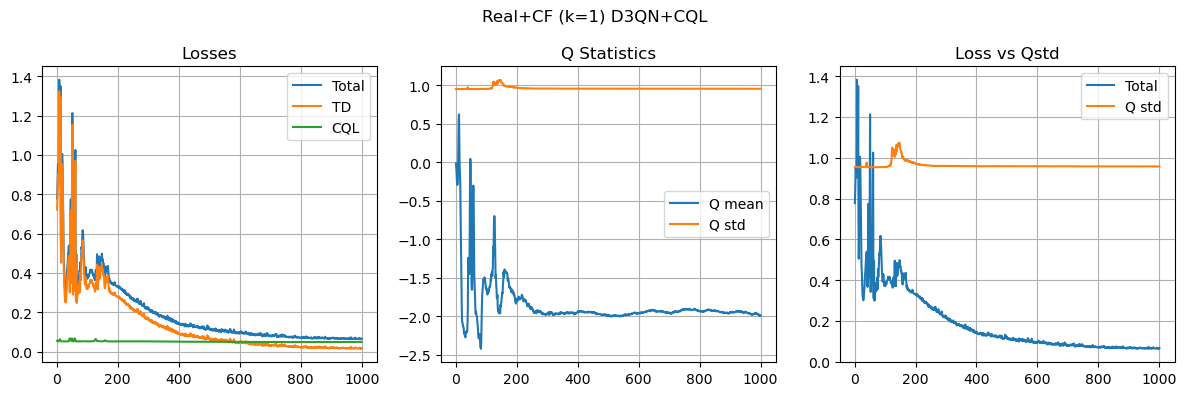


================ FINAL EVALUATION ================
Mean return: 27.100000381469727
Std return : 18.788028717041016



In [3]:
cf_stats,final_returns_cf=main(USE_CF=True,CF_K_PER_REAL = 1 )


/var/folders/1_/jmlm_4tj4k18gv9r77l0vwkw0000gn/T/ipykernel_24073/750496479.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  real_data = torch.load("SD_dataset_clean.pt"

Loading CLEAN SD dataset...
Dataset transitions: 4149

========== OFFLINE D3QN TRAINING: Real-only D3QN+CQL ==========


D3QN Epochs:   0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000 | TD=0.8502 | CQL=0.0546 | Total=0.9048 | Qmean=-0.010 | Qstd=0.954


D3QN Epochs:   0%|▏                                                                                 | 2/1000 [00:00<06:14,  2.67it/s]

   ▶ Eval Return Mean = 246.65, Std = 154.26


D3QN Epochs:   2%|█▋                                                                               | 21/1000 [00:03<02:16,  7.19it/s]

Epoch 20/1000 | TD=0.6709 | CQL=0.0476 | Total=0.7185 | Qmean=-0.262 | Qstd=0.954
   ▶ Eval Return Mean = 15.90, Std = 5.72


D3QN Epochs:   4%|███▎                                                                             | 41/1000 [00:06<02:12,  7.24it/s]

Epoch 40/1000 | TD=0.5286 | CQL=0.0433 | Total=0.5719 | Qmean=-0.335 | Qstd=0.954
   ▶ Eval Return Mean = 15.60, Std = 7.95


D3QN Epochs:   6%|████▉                                                                            | 61/1000 [00:08<02:10,  7.22it/s]

Epoch 60/1000 | TD=0.4389 | CQL=0.0396 | Total=0.4785 | Qmean=-0.386 | Qstd=0.954
   ▶ Eval Return Mean = 18.10, Std = 9.91


D3QN Epochs:   8%|██████▌                                                                          | 81/1000 [00:11<02:07,  7.23it/s]

Epoch 80/1000 | TD=0.3648 | CQL=0.0361 | Total=0.4009 | Qmean=-0.414 | Qstd=0.954
   ▶ Eval Return Mean = 16.10, Std = 7.73


D3QN Epochs:  10%|████████                                                                        | 101/1000 [00:14<02:05,  7.14it/s]

Epoch 100/1000 | TD=0.3193 | CQL=0.0338 | Total=0.3530 | Qmean=-0.435 | Qstd=0.954
   ▶ Eval Return Mean = 19.10, Std = 13.47


D3QN Epochs:  12%|█████████▋                                                                      | 121/1000 [00:16<02:00,  7.27it/s]

Epoch 120/1000 | TD=0.2884 | CQL=0.0312 | Total=0.3196 | Qmean=-0.449 | Qstd=0.954
   ▶ Eval Return Mean = 16.15, Std = 8.53


D3QN Epochs:  14%|███████████▎                                                                    | 141/1000 [00:19<01:59,  7.19it/s]

Epoch 140/1000 | TD=0.2643 | CQL=0.0289 | Total=0.2933 | Qmean=-0.465 | Qstd=0.954
   ▶ Eval Return Mean = 19.95, Std = 10.28


D3QN Epochs:  16%|████████████▉                                                                   | 161/1000 [00:21<01:57,  7.14it/s]

Epoch 160/1000 | TD=0.2624 | CQL=0.0277 | Total=0.2901 | Qmean=-0.478 | Qstd=0.954
   ▶ Eval Return Mean = 19.90, Std = 10.52


D3QN Epochs:  18%|██████████████▍                                                                 | 181/1000 [00:24<01:55,  7.10it/s]

Epoch 180/1000 | TD=0.2575 | CQL=0.0264 | Total=0.2839 | Qmean=-0.491 | Qstd=0.954
   ▶ Eval Return Mean = 21.25, Std = 7.50


D3QN Epochs:  20%|████████████████                                                                | 201/1000 [00:27<01:53,  7.02it/s]

Epoch 200/1000 | TD=0.2529 | CQL=0.0255 | Total=0.2784 | Qmean=-0.505 | Qstd=0.954
   ▶ Eval Return Mean = 22.30, Std = 13.52


D3QN Epochs:  22%|█████████████████▋                                                              | 221/1000 [00:29<01:51,  7.01it/s]

Epoch 220/1000 | TD=0.2541 | CQL=0.0248 | Total=0.2789 | Qmean=-0.514 | Qstd=0.954
   ▶ Eval Return Mean = 25.45, Std = 20.46


D3QN Epochs:  24%|███████████████████▎                                                            | 241/1000 [00:32<01:47,  7.06it/s]

Epoch 240/1000 | TD=0.2285 | CQL=0.0233 | Total=0.2518 | Qmean=-0.524 | Qstd=0.954
   ▶ Eval Return Mean = 23.50, Std = 10.41


D3QN Epochs:  26%|████████████████████▉                                                           | 261/1000 [00:35<01:47,  6.90it/s]

Epoch 260/1000 | TD=0.2249 | CQL=0.0226 | Total=0.2474 | Qmean=-0.533 | Qstd=0.954
   ▶ Eval Return Mean = 23.40, Std = 12.06


D3QN Epochs:  28%|██████████████████████▍                                                         | 281/1000 [00:38<01:48,  6.61it/s]

Epoch 280/1000 | TD=0.2182 | CQL=0.0217 | Total=0.2399 | Qmean=-0.540 | Qstd=0.954
   ▶ Eval Return Mean = 17.35, Std = 7.26


D3QN Epochs:  30%|████████████████████████                                                        | 301/1000 [00:40<01:38,  7.12it/s]

Epoch 300/1000 | TD=0.2146 | CQL=0.0212 | Total=0.2358 | Qmean=-0.547 | Qstd=0.954
   ▶ Eval Return Mean = 20.05, Std = 8.79


D3QN Epochs:  32%|█████████████████████████▋                                                      | 321/1000 [00:43<01:35,  7.09it/s]

Epoch 320/1000 | TD=0.2579 | CQL=0.0215 | Total=0.2795 | Qmean=-0.556 | Qstd=0.954
   ▶ Eval Return Mean = 21.40, Std = 18.02


D3QN Epochs:  34%|███████████████████████████▎                                                    | 341/1000 [00:46<01:45,  6.22it/s]

Epoch 340/1000 | TD=0.2336 | CQL=0.0208 | Total=0.2544 | Qmean=-0.565 | Qstd=0.954
   ▶ Eval Return Mean = 23.65, Std = 11.06


D3QN Epochs:  36%|████████████████████████████▉                                                   | 361/1000 [00:49<01:38,  6.48it/s]

Epoch 360/1000 | TD=0.2063 | CQL=0.0198 | Total=0.2261 | Qmean=-0.573 | Qstd=0.954
   ▶ Eval Return Mean = 19.55, Std = 8.18


D3QN Epochs:  38%|██████████████████████████████▍                                                 | 381/1000 [00:52<01:36,  6.38it/s]

Epoch 380/1000 | TD=0.2109 | CQL=0.0197 | Total=0.2306 | Qmean=-0.580 | Qstd=0.954
   ▶ Eval Return Mean = 19.70, Std = 14.20


D3QN Epochs:  40%|████████████████████████████████                                                | 400/1000 [00:55<01:39,  6.02it/s]

Epoch 400/1000 | TD=0.2473 | CQL=0.0201 | Total=0.2674 | Qmean=-0.584 | Qstd=0.954
   ▶ Eval Return Mean = 23.80, Std = 17.42


D3QN Epochs:  42%|█████████████████████████████████▌                                              | 420/1000 [00:58<01:49,  5.29it/s]

Epoch 420/1000 | TD=0.2122 | CQL=0.0191 | Total=0.2313 | Qmean=-0.590 | Qstd=0.954
   ▶ Eval Return Mean = 34.05, Std = 24.24


D3QN Epochs:  44%|███████████████████████████████████▏                                            | 440/1000 [01:01<01:32,  6.04it/s]

Epoch 440/1000 | TD=0.2216 | CQL=0.0192 | Total=0.2408 | Qmean=-0.595 | Qstd=0.954
   ▶ Eval Return Mean = 24.30, Std = 15.00


D3QN Epochs:  46%|████████████████████████████████████▉                                           | 461/1000 [01:05<01:33,  5.77it/s]

Epoch 460/1000 | TD=0.1911 | CQL=0.0184 | Total=0.2094 | Qmean=-0.599 | Qstd=0.954
   ▶ Eval Return Mean = 18.15, Std = 8.68


D3QN Epochs:  48%|██████████████████████████████████████▍                                         | 480/1000 [01:08<01:29,  5.80it/s]

Epoch 480/1000 | TD=0.1781 | CQL=0.0177 | Total=0.1958 | Qmean=-0.600 | Qstd=0.954
   ▶ Eval Return Mean = 25.90, Std = 14.55


D3QN Epochs:  50%|████████████████████████████████████████                                        | 500/1000 [01:11<01:27,  5.69it/s]

Epoch 500/1000 | TD=0.1970 | CQL=0.0177 | Total=0.2147 | Qmean=-0.606 | Qstd=0.954
   ▶ Eval Return Mean = 28.45, Std = 20.02


D3QN Epochs:  52%|█████████████████████████████████████████▌                                      | 520/1000 [01:14<01:20,  5.93it/s]

Epoch 520/1000 | TD=0.1765 | CQL=0.0177 | Total=0.1942 | Qmean=-0.612 | Qstd=0.954
   ▶ Eval Return Mean = 20.70, Std = 7.91


D3QN Epochs:  54%|███████████████████████████████████████████▎                                    | 541/1000 [01:17<01:13,  6.22it/s]

Epoch 540/1000 | TD=0.1932 | CQL=0.0177 | Total=0.2109 | Qmean=-0.617 | Qstd=0.954
   ▶ Eval Return Mean = 23.50, Std = 13.75


D3QN Epochs:  56%|████████████████████████████████████████████▊                                   | 560/1000 [01:20<01:21,  5.41it/s]

Epoch 560/1000 | TD=0.1537 | CQL=0.0166 | Total=0.1703 | Qmean=-0.619 | Qstd=0.954
   ▶ Eval Return Mean = 25.45, Std = 11.06


D3QN Epochs:  58%|██████████████████████████████████████████████▍                                 | 580/1000 [01:23<01:13,  5.73it/s]

Epoch 580/1000 | TD=0.1851 | CQL=0.0172 | Total=0.2023 | Qmean=-0.623 | Qstd=0.954
   ▶ Eval Return Mean = 24.65, Std = 14.12


D3QN Epochs:  60%|████████████████████████████████████████████████                                | 600/1000 [01:27<01:08,  5.82it/s]

Epoch 600/1000 | TD=0.1572 | CQL=0.0161 | Total=0.1734 | Qmean=-0.625 | Qstd=0.954
   ▶ Eval Return Mean = 24.55, Std = 11.88


D3QN Epochs:  62%|█████████████████████████████████████████████████▋                              | 621/1000 [01:30<00:54,  6.97it/s]

Epoch 620/1000 | TD=0.1847 | CQL=0.0167 | Total=0.2014 | Qmean=-0.627 | Qstd=0.954
   ▶ Eval Return Mean = 24.40, Std = 17.17


D3QN Epochs:  64%|███████████████████████████████████████████████████▎                            | 641/1000 [01:32<00:51,  6.94it/s]

Epoch 640/1000 | TD=0.1960 | CQL=0.0167 | Total=0.2127 | Qmean=-0.630 | Qstd=0.954
   ▶ Eval Return Mean = 25.80, Std = 17.49


D3QN Epochs:  66%|████████████████████████████████████████████████████▉                           | 661/1000 [01:35<00:48,  7.03it/s]

Epoch 660/1000 | TD=0.1544 | CQL=0.0157 | Total=0.1700 | Qmean=-0.632 | Qstd=0.954
   ▶ Eval Return Mean = 24.05, Std = 10.61


D3QN Epochs:  68%|██████████████████████████████████████████████████████▍                         | 681/1000 [01:38<00:45,  7.07it/s]

Epoch 680/1000 | TD=0.1945 | CQL=0.0165 | Total=0.2110 | Qmean=-0.636 | Qstd=0.954
   ▶ Eval Return Mean = 25.05, Std = 13.64


D3QN Epochs:  70%|████████████████████████████████████████████████████████                        | 701/1000 [01:41<00:43,  6.94it/s]

Epoch 700/1000 | TD=0.1515 | CQL=0.0156 | Total=0.1671 | Qmean=-0.638 | Qstd=0.954
   ▶ Eval Return Mean = 23.80, Std = 11.31


D3QN Epochs:  72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [01:43<00:42,  6.53it/s]

Epoch 720/1000 | TD=0.1479 | CQL=0.0152 | Total=0.1631 | Qmean=-0.640 | Qstd=0.954
   ▶ Eval Return Mean = 33.90, Std = 23.67


D3QN Epochs:  74%|███████████████████████████████████████████████████████████▎                    | 741/1000 [01:47<00:42,  6.13it/s]

Epoch 740/1000 | TD=0.1428 | CQL=0.0151 | Total=0.1578 | Qmean=-0.640 | Qstd=0.954
   ▶ Eval Return Mean = 27.20, Std = 21.89


D3QN Epochs:  76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [01:49<00:41,  5.76it/s]

Epoch 760/1000 | TD=0.1451 | CQL=0.0149 | Total=0.1600 | Qmean=-0.643 | Qstd=0.954
   ▶ Eval Return Mean = 30.35, Std = 23.97


D3QN Epochs:  78%|██████████████████████████████████████████████████████████████▍                 | 781/1000 [01:53<00:35,  6.24it/s]

Epoch 780/1000 | TD=0.1342 | CQL=0.0149 | Total=0.1490 | Qmean=-0.646 | Qstd=0.954
   ▶ Eval Return Mean = 19.60, Std = 11.04


D3QN Epochs:  80%|████████████████████████████████████████████████████████████████                | 800/1000 [01:56<00:32,  6.15it/s]

Epoch 800/1000 | TD=0.1906 | CQL=0.0156 | Total=0.2062 | Qmean=-0.649 | Qstd=0.954
   ▶ Eval Return Mean = 23.65, Std = 5.76


D3QN Epochs:  82%|█████████████████████████████████████████████████████████████████▋              | 821/1000 [01:59<00:27,  6.44it/s]

Epoch 820/1000 | TD=0.1442 | CQL=0.0149 | Total=0.1591 | Qmean=-0.651 | Qstd=0.954
   ▶ Eval Return Mean = 27.50, Std = 13.80


D3QN Epochs:  84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [02:02<00:26,  6.04it/s]

Epoch 840/1000 | TD=0.1507 | CQL=0.0147 | Total=0.1654 | Qmean=-0.655 | Qstd=0.954
   ▶ Eval Return Mean = 28.55, Std = 20.06


D3QN Epochs:  86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [02:05<00:23,  6.00it/s]

Epoch 860/1000 | TD=0.1272 | CQL=0.0144 | Total=0.1416 | Qmean=-0.659 | Qstd=0.954
   ▶ Eval Return Mean = 31.65, Std = 19.39


D3QN Epochs:  88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [02:07<00:18,  6.45it/s]

Epoch 880/1000 | TD=0.1527 | CQL=0.0146 | Total=0.1673 | Qmean=-0.661 | Qstd=0.954
   ▶ Eval Return Mean = 21.00, Std = 11.34


D3QN Epochs:  90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [02:11<00:17,  5.84it/s]

Epoch 900/1000 | TD=0.1248 | CQL=0.0139 | Total=0.1387 | Qmean=-0.662 | Qstd=0.954
   ▶ Eval Return Mean = 21.50, Std = 6.83


D3QN Epochs:  92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [02:14<00:13,  5.80it/s]

Epoch 920/1000 | TD=0.1199 | CQL=0.0141 | Total=0.1340 | Qmean=-0.665 | Qstd=0.954
   ▶ Eval Return Mean = 32.80, Std = 23.22


D3QN Epochs:  94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [02:17<00:09,  6.09it/s]

Epoch 940/1000 | TD=0.1267 | CQL=0.0144 | Total=0.1411 | Qmean=-0.670 | Qstd=0.954
   ▶ Eval Return Mean = 23.80, Std = 11.40


D3QN Epochs:  96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [02:20<00:07,  5.48it/s]

Epoch 960/1000 | TD=0.1202 | CQL=0.0141 | Total=0.1343 | Qmean=-0.670 | Qstd=0.954
   ▶ Eval Return Mean = 29.40, Std = 18.44


D3QN Epochs:  98%|██████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [02:23<00:02,  6.80it/s]

Epoch 980/1000 | TD=0.1226 | CQL=0.0138 | Total=0.1365 | Qmean=-0.671 | Qstd=0.954
   ▶ Eval Return Mean = 29.95, Std = 19.34


D3QN Epochs: 100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.86it/s]

Epoch 1000/1000 | TD=0.1299 | CQL=0.0139 | Total=0.1438 | Qmean=-0.672 | Qstd=0.954
   ▶ Eval Return Mean = 46.70, Std = 71.16


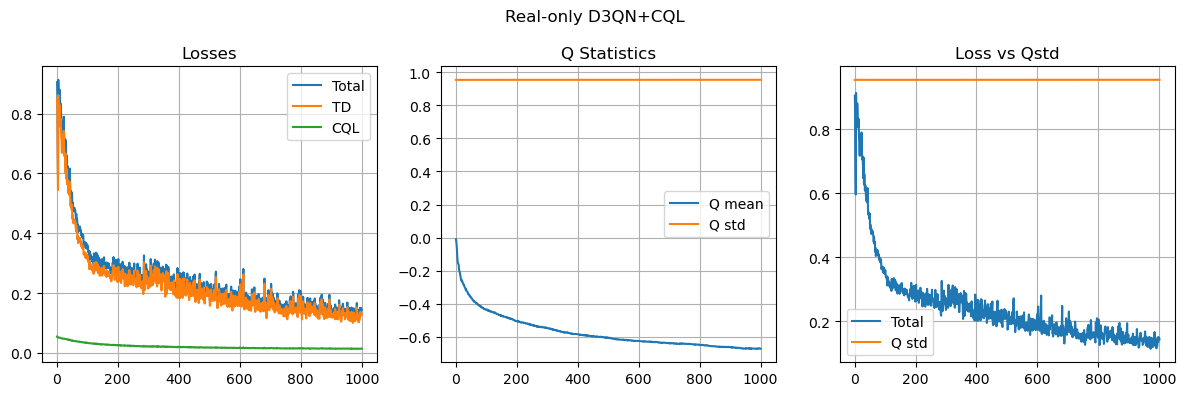


================ FINAL EVALUATION ================
Mean return: 46.70000076293945
Std return : 71.15623474121094



In [4]:
real_stats,final_returns_real=main(USE_CF=False,CF_K_PER_REAL = 1 )




=== Real Means (clean) ===
Count: 49
Mean : 23.589
Std  : 4.643
Min  : 15.600
Max  : 34.050

=== CF Means (clean) ===
Count: 45
Mean : 24.600
Std  : 9.026
Min  : 9.450
Max  : 49.900

=== Real Variances (clean) ===
Count: 49
Mean : 210.675
Std  : 155.990
Min  : 32.696
Max  : 587.772

=== CF Variances (clean) ===
Count: 44
Mean : 217.036
Std  : 146.092
Min  : 0.448
Max  : 614.643


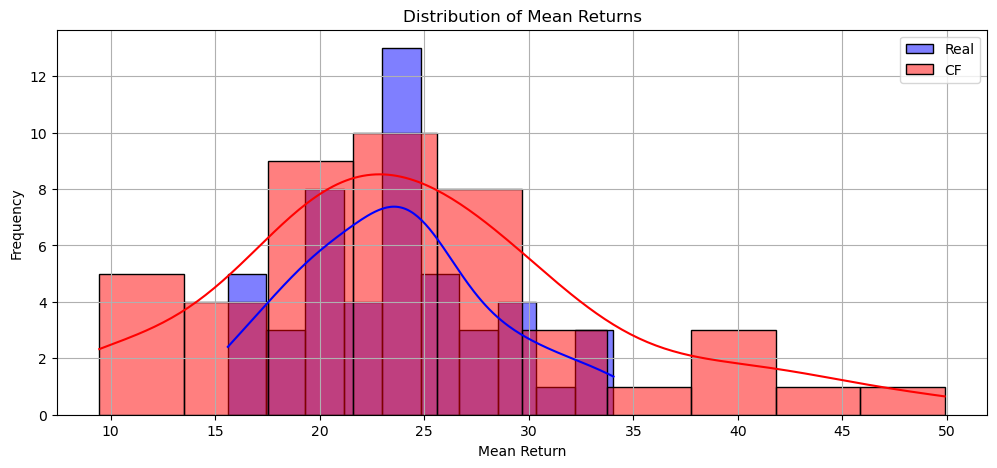

/var/folders/1_/jmlm_4tj4k18gv9r77l0vwkw0000gn/T/ipykernel_24073/750496479.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([real_means_clean, cf_means_clean], labels=["Real", "CF"])


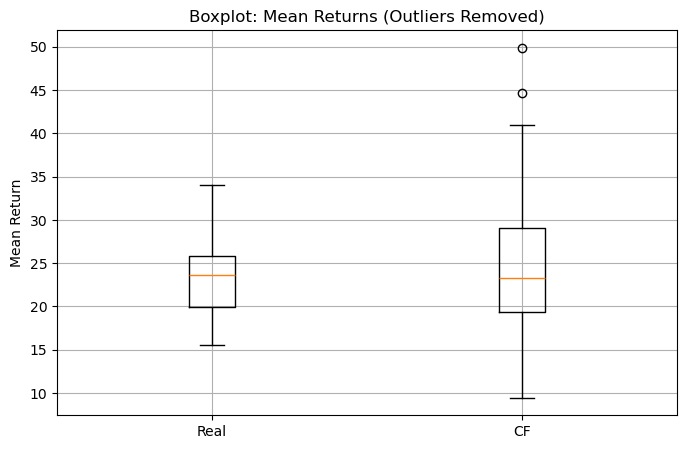

/var/folders/1_/jmlm_4tj4k18gv9r77l0vwkw0000gn/T/ipykernel_24073/750496479.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([real_vars_clean, cf_vars_clean], labels=["Real", "CF"])


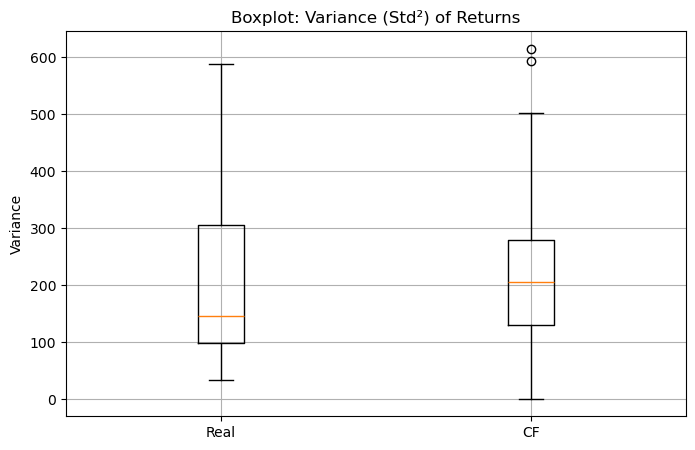

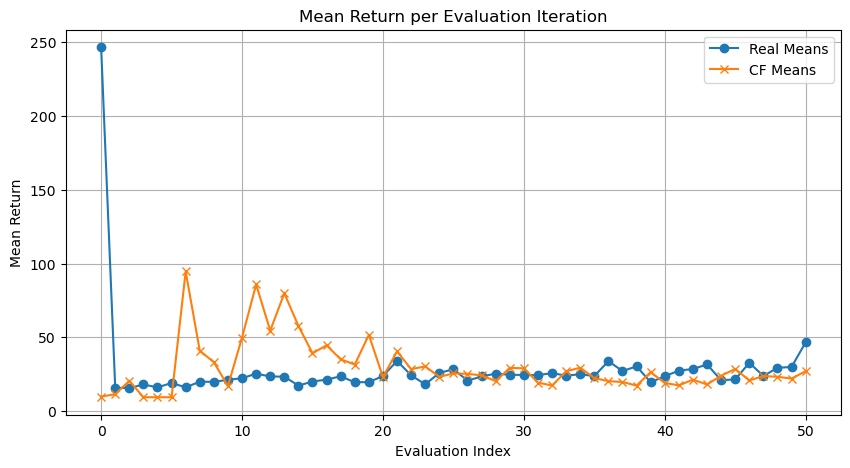

In [5]:
   

real_means = np.array([m for m, s in real_stats])
real_vars  = np.array([s**2 for m, s in real_stats])

cf_means = np.array([m for m, s in cf_stats])
cf_vars  = np.array([s**2 for m, s in cf_stats])

real_means_clean = remove_outliers(real_means)
cf_means_clean   = remove_outliers(cf_means)

real_vars_clean  = remove_outliers(real_vars)
cf_vars_clean    = remove_outliers(cf_vars)

summary("Real Means (clean)", real_means_clean)
summary("CF Means (clean)", cf_means_clean)
summary("Real Variances (clean)", real_vars_clean)
summary("CF Variances (clean)", cf_vars_clean)
diagnostic_plots(real_means_clean,cf_means_clean,real_means,cf_means,real_vars_clean, cf_vars_clean)

In [ ]:
# if __name__ == "__main__":
#     # -----------------------------
#     # 0. CONFIG
#     # -----------------------------
#     USE_CF = True      # <<< set True when you wire in BiCoGAN loading
#     CF_K_PER_REAL = 1   # how many CF transitions per real transition

#     # -----------------------------
#     # 1. Load clean SD dataset
#     # -----------------------------
#     print("Loading CLEAN SD dataset...")
#     real_data = torch.load("SD_dataset_clean.pt")

#     # Optionally load BiCoGAN models and build real+CF buffer
#     if USE_CF:
#         #G, E = load_bicogan_models()
#         S_raw, A, R, SP_raw = build_training_buffer(
#             real_data,
#             use_cf=True,
#             G=G,
#             E=E,
#             cf_k=CF_K_PER_REAL,
#         )
#         label = f"Real+CF (k={CF_K_PER_REAL}) D3QN+CQL"
#     else:
#         # Real-only
#         S_raw = real_data["s"].float().reshape(-1, 4)
#         A     = real_data["a"].long().reshape(-1)
#         R     = real_data["r"].float().reshape(-1)
#         SP_raw = real_data["sp"].float().reshape(-1, 4)
#         label = "Real-only D3QN+CQL"

#     N = S_raw.shape[0]
#     print("Dataset transitions:", N)

#     # -----------------------------
#     # 2. Termination flags from NEXT state (clean thresholds)
#     # -----------------------------
#     D = (
#         (SP_raw[:, 0] < -2.4)
#         | (SP_raw[:, 0] > 2.4)
#         | (SP_raw[:, 2] < -0.2095)
#         | (SP_raw[:, 2] > 0.2095)
#     ).float()

#     # -----------------------------
#     # 3. State normalization
#     # -----------------------------
#     S_mean = S_raw.mean(dim=0, keepdim=True)
#     S_std  = S_raw.std(dim=0, keepdim=True) + 1e-6

#     S  = (S_raw  - S_mean) / S_std
#     SP = (SP_raw - S_mean) / S_std

#     # -----------------------------
#     # 4. Hyperparameters
#     # -----------------------------
#     hyper = D3QNHyperParams()

#     # -----------------------------
#     # 5. Train offline D3QN + CQL
#     # -----------------------------
#     q_net, tot, tdl, cql, qmean, qstd,valist = train_offline_d3qn(
#         S,
#         A,
#         R,
#         SP,
#         D,
#         hyper,
#         S_mean,
#         S_std,
#         eval_every=20,
#         label=label,
#     )

#     # -----------------------------
#     # 6. Plot training curves
#     # -----------------------------
#     plot_d3qn_training(tot, tdl, cql, qmean, qstd, title=label)

#     # -----------------------------
#     # 7. Final evaluation on clean CartPole
#     # -----------------------------
#     final_returns = evaluate_policy(q_net, S_mean, S_std, episodes=20)
#     print("\n================ FINAL EVALUATION ================")
#     print("Mean return:", float(final_returns.mean()))
#     print("Std return :", float(final_returns.std()))
#     print("=================================================\n")